<table width=60% >
    <tr style="background-color: white;">
        <td><img src='https://www.creativedestructionlab.com/wp-content/uploads/2018/05/xanadu.jpg'></td>
        <td><img src='https://www.creativedestructionlab.com/wp-content/uploads/2016/10/creative-destruction-lab.png' ></td>
    </tr>
</table>

---

<img src='https://raw.githubusercontent.com/XanaduAI/strawberryfields/master/doc/_static/strawberry-fields-text.png'>

---

<br>

<center> <h1> State learning tutorial </h1></center>

Now that we are more familiar with Strawberry Fields, let's have a go using the TensorFlow backend to do some quantum circuit optimization. This functionality is provided via the Tensorflow simulator backend. By leveraging Tensorflow, we have access to a number of additional funtionalities, including GPU integration, automatic gradient computation, built-in optimization algorithms, and other machine learning tools.

# Background information

## Using the TensorFlow backend

Using the TensorFlow backend is similar to using the Fock and Gaussian backend in the previous tutorials, however there are a couple of slight subtleties that need to be accounted for.

We import Strawberry Fields as before, and create the quantum engine:

In [1]:
import strawberryfields as sf
from strawberryfields.ops import *

eng, q = sf.Engine(2)

When a circuit contains only numerical parameters, the Tensorflow simulator backend works the same as the other backends. However, with the Tensorflow backend, we have the additional option to use Tensorflow objects (e.g., `tf.Variable`, `tf.constant`, `tf.placeholder`, or `tf.Tensor`) for the parameters of quantum states, gates, and measurements.

In [2]:
import tensorflow as tf

alpha = tf.Variable(0.5)
theta_bs = tf.constant(0.0)
phi_bs = tf.sigmoid(0.0) # this will be a tf.Tensor object
phi = tf.placeholder(tf.float32)

with eng:
    # States
    Coherent(alpha)            | q[0]

    # Gates
    BSgate(theta_bs, phi_bs)   | (q[0], q[1])

    # Measurements
    MeasureHomodyne(phi)       | q[0]

To run a Strawberry Fields simulation with the Tensorflow backend, we need to specify `'tf'` as the backend argument when calling `eng.run()`. However, directly evaluating a circuit which contains Tensorflow objects using `eng.run()` will produce errors. The reason for this is that `eng.run()` tries, by default, to numerically evaluate any measurement result. But Tensorflow requires several extra ingredients to do this:

* Numerical computations must be carried out using a `tf.Session`.
* All `tf.Variable` objects must be initialized within this `tf.Session` (the initial values are supplied when creating the variables).
* Numerical values must be provided for any `tf.placeholder` objects using a feed dictionary (`feed_dict`).

The solution is to perform the simulation *symbolically*, using the keyword argument `eval=False`. The final state and the register q will both instead contain unevaluted Tensors. These Tensors can be evaluated numerically by running the `tf.Session` and supplying the desired values for any placeholders:

In [3]:
# eval=False tells it to perform the simulation not numerically, so the tensor (tensorflow) returned is not evaluated numerically, it's symbolicall
state = eng.run('tf', cutoff_dim=7, eval=False)

## Example

In [4]:
eng, q = sf.Engine(2)

with eng:
    Dgate(alpha)         | q[0]
    MeasureHomodyne(phi) | q[0]

state = eng.run('tf', cutoff_dim=7, eval=False)

Measurement values and state properties/methods will now return unevaluated, symbolic tensors:

In [5]:
state_density_matrix = state.dm()

In [6]:
print(state.dm())

Tensor("einsum_1/transpose_2:0", shape=(7, 7, 7, 7), dtype=complex64)


In [7]:
homodyne_meas = q[0].val

In [8]:
print(q[0].val)

Tensor("Measure_homodyne_1/Meas_result:0", shape=(), dtype=float64)


We can evaluate these tensors by calling Tensorflow's `sess.run` method:

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
dm_x, meas_x = sess.run([state_density_matrix, homodyne_meas], feed_dict={phi: 0.0})

In [10]:
print(meas_x)

0.7149071490714913


<div class="alert alert-success" style="border: 0px; border-left: 3px solid #119a68; color: black; background-color: #daf0e9">
<p style="color: #119a68;">**Note**</p>When being used as a numerical simulator (similar to the other backends), the Tensorflow backend creates temporary sessions in order to evaluate measurement results numerically.
</div>

## Processing data

The parameters for Blackbird states, gates, and measurements may be more complex than just raw data or machine learning weights. These can themselves be the outputs from some learnable function like a neural network:

In [11]:
input_ = tf.placeholder(tf.float32, shape=(2,1))
weights = tf.Variable([[0.1,0.1]])
bias = tf.Variable(0.0)

NN = tf.sigmoid(tf.matmul(weights, input_) + bias)
NNDgate = Dgate(NN)

We can also use the `sf.convert()` decorator to allow arbitrary processing of measurement results with the Tensorflow backend:

In [12]:
@sf.convert
def sigmoid(x):
    return tf.sigmoid(x)

with eng:
    MeasureX             | q[0]
    Dgate(sigmoid(q[0])) | q[1]

## Working with batches

It is common in machine learning to process data in batches. Strawberry Fields supports both unbatched and batched data when using the Tensorflow backend. Unbatched operation is the default behaviour (shown above). To enable batched operation, you should provide an extra batch_size argument when calling `eng.run()`, e.g.,

In [13]:
# run simulation in batched-processing mode
batch_size = 3
eng, q = sf.Engine(2)

with eng:
    Dgate(tf.Variable([0.1] * batch_size)) | q[0]

state = eng.run('tf', cutoff_dim=7, eval=False, batch_size=batch_size)

Parameters supplied to a circuit in batch-mode operation can either be scalars or vectors (of length batch_size). Scalars are **automatically broadcast** over the batch dimension.

In [14]:
alpha = tf.Variable([0.5] * batch_size)
theta = tf.constant(0.0)
phi = tf.Variable([0.1, 0.33, 0.5])

Measurement results will be returned as Tensors with shape `(batch_size,)`. We can picture batch-mode operation as simulating multiple circuit configurations at the same time. Combined with appropriate parallelized hardware like GPUs, this can result in significant speedups compared to serial evaluation.

In [15]:
state

<FockStateTF: num_modes=2, cutoff=7, pure=True, batched=True, hbar=2>

In [16]:
state.ket().shape

TensorShape([Dimension(3), Dimension(7), Dimension(7)])

## Example: variational quantum circuit optimization

A key element of machine learning is optimization. We can use Tensorflow’s automatic differentiation tools to optimize the parameters of variational quantum circuits. In this approach, we fix a circuit architecture where the states, gates, and/or measurements may have learnable parameters associated with them. We then define a loss function based on the output state of this circuit.


<div class="alert alert-info" style="border: 0px; border-left: 3px solid #31708f; color: black; background-color: #d9edf7">
<p style="color: #31708f;">**Exercise**</p>

Complete the Strawberry Fields program below, to optimize a Dgate to produce an output with the largest overlap with the Fock state $n=1$.

</div>


In [17]:
#!/usr/bin/env python3
import strawberryfields as sf
from strawberryfields.ops import *
import tensorflow as tf

# create a one mode engine
eng, q = sf.Engine(1)

# The displacement parameter is a TF variable - the one we want to optimize
alpha = tf.Variable(0.1)

# Apply a Dgate with this parameter to the qumode
# and run the engine using the Tensorflow backend
# in symbolic mode

with eng:
    Dgate(alpha) | q[0]

state = eng.run('tf', cutoff_dim=6, eval=False)
    
# calculate the probability of the 
# resulting state being in Fock state |1>
prob = state.fock_prob([1])


# The loss function:
# Loss is the probability for the Fock state n=1.
# Note that we add a negative sign since
# we wish to *maximize* the probability overlap
loss = -prob  

# Set up optimization
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
minimize_op = optimizer.minimize(loss)

# Create Tensorflow Session and initialize variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Carry out optimization
for step in range(50):
    prob_val, alpha_val, _ = sess.run([prob, alpha, minimize_op])
    print("Value at step {}: {}".format(step, prob_val, alpha_val))

Value at step 0: 0.00990049634128809
Value at step 1: 0.014101705513894558
Value at step 2: 0.019992981106042862
Value at step 3: 0.0281626395881176
Value at step 4: 0.039317384362220764
Value at step 5: 0.054226942360401154
Value at step 6: 0.07359194755554199
Value at step 7: 0.09781551361083984
Value at step 8: 0.12670716643333435
Value at step 9: 0.15923479199409485
Value at step 10: 0.19351372122764587
Value at step 11: 0.22716644406318665
Value at step 12: 0.2579536437988281
Value at step 13: 0.2843506336212158
Value at step 14: 0.30577120184898376
Value at step 15: 0.32241666316986084
Value at step 16: 0.3349469006061554
Value at step 17: 0.3441750109195709
Value at step 18: 0.35087576508522034
Value at step 19: 0.3556998074054718
Value at step 20: 0.3591567277908325
Value at step 21: 0.3616286516189575
Value at step 22: 0.36339545249938965
Value at step 23: 0.36465880274772644
Value at step 24: 0.365563303232193
Value at step 25: 0.36621156334877014
Value at step 26: 0.36667701

<div class="alert alert-info" style="border: 0px; border-left: 3px solid #31708f; color: black; background-color: #d9edf7">
<p style="color: #31708f;">**Exercise**</p>

Plot the Wigner function for the single photon state, and compare it to the optimized state above.

</div>

First, you need to numerically evaluate the density matrix of the state.

In [18]:
eng, q = sf.Engine(1)

with eng:
    # prepare the initial states
    Coherent(1+0j) | q[0] 

state = eng.run('fock', cutoff_dim=100, eval=False)
    
rho = state.dm()
print(rho.shape)
prob = state.fock_prob([1])
print(prob)

(100, 100)
0.36787944117144233


The following Wigner function is provided for convenience.

In [19]:
# Wigner function for plotting purposes
def wigner(rho):
    import copy
    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m)
                    * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)

# Layers and state learning

For arbitrary state preparation using optimization, we need to make use of a quantum circuit with a layer structure that is **universal** - that is, by 'stacking' the layers, we can guarantee that we can produce *any* CV state. Therefore, the architecture we choose must consist of layers with each layer containing parameterized Gaussian *and* non-Gaussian gates. **The non-Gaussian gates provide both the nonlinearity and the universality of the model.**

![layer](https://i.imgur.com/NEsaVIX.png)


<div class="alert alert-success" style="border: 0px; border-left: 3px solid #119a68; color: black; background-color: #daf0e9">
<p style="color: #119a68;">**Reference**</p>Killoran, N., Bromley, T. R., Arrazola, J. M., Schuld, M., Quesada, N., & Lloyd, S. (2018). "Continuous-variable quantum neural networks." [arXiv:1806.06871.](https://arxiv.org/abs/1806.06871)
</div>

First, we must define the **hyperparameters** of our layer structure:

* `cutoff`: the Fock space truncation we will use in the optimization. The TensorFlow backend will perform operations in this truncated Fock space when performing the optimization.


* `depth`: The number of layers in our quantum circuit. As a general rule, increasing the number of layers (and thus, the number of parameters we are optimizing over) increases the optimizers chance of finding a reasonable local minimum in the optimization landscape.


* `reps`: the number of steps in optimization routine performing gradient descent

Some other optional hyperparameters include:

* `penalty_strength`: this allows us to *penalize* deviations from a trace of 1 in the cost function. This helps ensure that the optimization process never results in operations that transform the state beyond the truncated Fock space.


* The standard deviation of initial parameters. Note that we make a distinction between the standard deviation of *passive* parameters (those that preserve photon number when changed, such as phase parameters), and *active* parameters (those that introduce or remove energy from the system when changed).

In [21]:
# Cutoff dimension
cutoff = 6 # 100 

# Number of layers
depth = 8

# Number of steps in optimization routine performing gradient descent
reps = 1000

# Penalty coefficient to ensure the state is normalized
penalty_strength = 100

# Standard deviation of initial parameters
passive_sd = 0.1
active_sd = 0.001

## The layer parameters

We use TensorFlow to create the variables corresponding to the gate parameters. Note that each variable has shape `[depth]`, with each individual element representing the gate parameter in layer $i$.

In [22]:
# parameters for one layer

# squeeze gate
sq_r = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))
sq_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# displacement gate
d_r = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))
d_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# rotation gates
r1 = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))
r2 = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# kerr gate
kappa = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))

## The layer function

Now, we can create a function to define the $i$th layer, acting on qumode `q`. This allows us to simply call this function in a loop later on when we build our circuit.

In [23]:
# layer architecture
def layer(i, q):
    Rgate(r1[i]) | q
    Sgate(sq_r[i], sq_phi[i]) | q
    Rgate(r2[i]) | q
    Dgate(d_r[i], d_phi[i]) | q
    Kgate(kappa[i]) | q

## Constructing the circuit

Now that we have defined our gate parameters and our layer structure, we can construct our variational quantum circuit. Note that, as before, we use the TensorFlow backend with `eval=False`.

In [24]:
# Start SF engine
engine, q = sf.Engine(1)

# Apply circuit of layers with corresponding depth
with engine:
    for k in range(depth):
        layer(k, q[0])

# Run engine
state = engine.run('tf', cutoff_dim=cutoff, eval=False)
ket = state.ket()
# dm = state.dm()

## Performing the optimization

$$\newcommand{ket}[1]{\left|#1\right\rangle}$$

With the TensorFlow backend calculating the resulting state of the circuit symbolically, we can use TensorFlow to optimize the gate parameters to minimize the cost function we specify. With state learning, the cost function we often wish to minimize is the **fidelity of the output state $\ket{\psi}$ with some target state $\ket{\psi_t}$**. This is defined as the overlap between the two states:

$$ \text{fidelity} = \left|\left\langle{\psi}\mid{\psi_t}\right\rangle\right|^2$$


<div class="alert alert-info" style="border: 0px; border-left: 3px solid #31708f; color: black; background-color: #d9edf7">
<p style="color: #31708f;">**Exercise**</p>

Define a target state you wish to learn using the variational quantum circuit below, and run the optimization. A good starting example is the single photon state $\ket{1}$.

</div>

In [25]:
# Fock basis
target_state = np.zeros([cutoff])
target_state[1] = 1
target_state

array([0., 1., 0., 0., 0., 0.])

Using this target state, we calculate the fidelity with the state exiting the variational circuit. Note that we must use TensorFlow functions to manipulate this data, as were are working with symbolic variables!

In [26]:
fidelity = tf.abs(tf.reduce_sum(tf.conj(ket) * target_state)) ** 2

We can use this to construct our cost function. We can also include the penalty on the trace, to ensure the trace of the system remains close to 1.

In [27]:
# Objective function to minimize
cost = (1-fidelity) + penalty_strength*tf.abs(1-state.trace())
tf.summary.scalar('cost', cost)

<tf.Tensor 'cost:0' shape=() dtype=string>

Now that the cost function is defined, we can define and run the optimization. Below, we choose the Adam optimizer that is built into TensorFlow.

In [28]:
# Using Adam algorithm for optimization
optimiser = tf.train.AdamOptimizer()
min_cost = optimiser.minimize(cost)

# Begin Tensorflow session
session = tf.Session()
session.run(tf.global_variables_initializer())

We then loop over all repetitions, storing the best predicted fidelity value. 

In [29]:
fid_progress = []
best_fid = 0

# Run optimization
for i in range(reps):

    # one repitition of the optimization
#     _, cost_val, fid_val, ket_val, dm_val = session.run([min_cost, cost, fidelity, ket, dm])
    _, cost_val, fid_val, ket_val = session.run([min_cost, cost, fidelity, ket])

    # Stores fidelity at each step
    fid_progress.append(fid_val)
    
    if fid_val > best_fid:
        # store the new best fidelity and best state
        best_fid = fid_val
        best_state = ket_val
#         best_dm = dm_val

    # Prints progress at every 10 reps
    if i % 10 == 0:
        print(i, fid_val)

0 3.4653958e-06
10 0.006272122
20 0.0298158
30 0.07789884
40 0.15270945
50 0.24674593
60 0.34635726
70 0.43836436
80 0.51471
90 0.5807837
100 0.647182
110 0.702844
120 0.738386
130 0.7652487
140 0.7893296
150 0.8127957
160 0.838295
170 0.86525273
180 0.89184624
190 0.91588163
200 0.93589264
210 0.95123184
220 0.96238625
230 0.9710167
240 0.9777715
250 0.98293316
260 0.9869097
270 0.989911
280 0.9921379
290 0.9938041
300 0.9950537
310 0.9960031
320 0.9967317
330 0.9973019
340 0.9977569
350 0.99812776
360 0.9984343
370 0.99868983
380 0.9989032
390 0.9990822
400 0.99923146
410 0.999357
420 0.9994605
430 0.99954635
440 0.9996169
450 0.99967587
460 0.9997233
470 0.9997635
480 0.99979794
490 0.9998261
500 0.99985063
510 0.99987054
520 0.9998882
530 0.99990284
540 0.99991536
550 0.99992573
560 0.9999354
570 0.9999424
580 0.9999492
590 0.9999547
600 0.9999591
610 0.9999627
620 0.99996567
630 0.999969
640 0.99997175
650 0.9999727
660 0.9999752
670 0.999977
680 0.9999789
690 0.99998045
700 0.999


<div class="alert alert-info" style="border: 0px; border-left: 3px solid #31708f; color: black; background-color: #d9edf7">
<p style="color: #31708f;">**Exercise**</p>

Plot the Wigner function of the learnt state and the target state.

</div>

[[0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


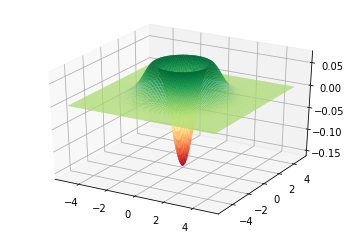

In [36]:
# desired state

rho = np.outer(target_state, target_state.conj())
print(rho)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)



The following cell computes the density matrix $\rho = \left|\psi\right\rangle \left\langle\psi\right|$ of a pure state vector. This can be used in the Wigner function defined in the previous section.

In [32]:
# learned state

rho = np.outer(best_state, best_state.conj())
print(rho)
print(rho.shape)

[[ 4.8271545e-07+0.0000000e+00j -2.1646306e-04+6.6019344e-04j
  -4.4793524e-07+5.8998523e-08j -1.5038297e-07-1.3434190e-07j
   1.5919306e-06+4.7474873e-07j  9.6461164e-08-4.7420562e-07j]
 [-2.1646306e-04-6.6019344e-04j  9.9999201e-01+0.0000000e+00j
   2.8155692e-04+5.8616913e-04j -1.1629891e-04+2.6591631e-04j
  -6.4568419e-05-2.3901197e-03j -6.9181068e-04+8.0720391e-05j]
 [-4.4793524e-07-5.8998523e-08j  2.8155692e-04-5.8616913e-04j
   4.2287189e-07+0.0000000e+00j  1.2312815e-07+1.4304254e-07j
  -1.4192053e-06-6.3511175e-07j -1.4746945e-07+4.2824888e-07j]
 [-1.5038297e-07+1.3434190e-07j -1.1629891e-04-2.6591631e-04j
   1.2312815e-07-1.4304254e-07j  8.4237591e-08+0.0000000e+00j
  -6.2806760e-07+2.9514047e-07j  1.0192251e-07+1.7457744e-07j]
 [ 1.5919306e-06-4.7474873e-07j -6.4568419e-05+2.3901197e-03j
  -1.4192053e-06+6.3511175e-07j -6.2806760e-07-2.9514047e-07j
   5.7168868e-06+0.0000000e+00j -1.4826347e-07-1.6587356e-06j]
 [ 9.6461164e-08+4.7420562e-07j -6.9181068e-04-8.0720391e-05j
  -

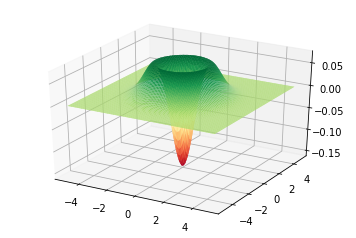

In [33]:



fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
